In [41]:
from obspy.core.event import read_events
import obspy
import numpy as np
import matplotlib.pyplot as plt
import os.path
import shutil
from obspy import UTCDateTime
from netCDF4 import Dataset
from matplotlib import cm
from skimage.filters import gaussian
from mpl_toolkits.basemap import Basemap

dpi = 300
FigFormat = "png"

../Runs/CartesianStandardRandomModel0000  created
-0.17146178721284128 0.21725303474058363
../Runs/CartesianStandardRandomModel0001  created
-0.2986718453321441 0.22304887619877434
../Runs/CartesianStandardRandomModel0002  created
-0.24668705492079307 0.273970193088086
../Runs/CartesianStandardRandomModel0003  created
-0.2544756312373822 0.16397988677746853
../Runs/CartesianStandardRandomModel0004  created
-0.23804729172696043 0.24527858625994609
../Runs/CartesianStandardRandomModel0005  created
-0.3271548621149796 0.1845351297834235
../Runs/CartesianStandardRandomModel0006  created
-0.2679213138385293 0.1830206943375654
../Runs/CartesianStandardRandomModel0007  created
-0.23004673992763422 0.2092588212284914
../Runs/CartesianStandardRandomModel0008  created
-0.2188216315186915 0.2746028640246623
../Runs/CartesianStandardRandomModel0009  created
-0.2608473197868982 0.26241702727229876
../Runs/CartesianStandardRandomModel0010  created
-0.27094721735575317 0.21496709217106194
../Runs/Car

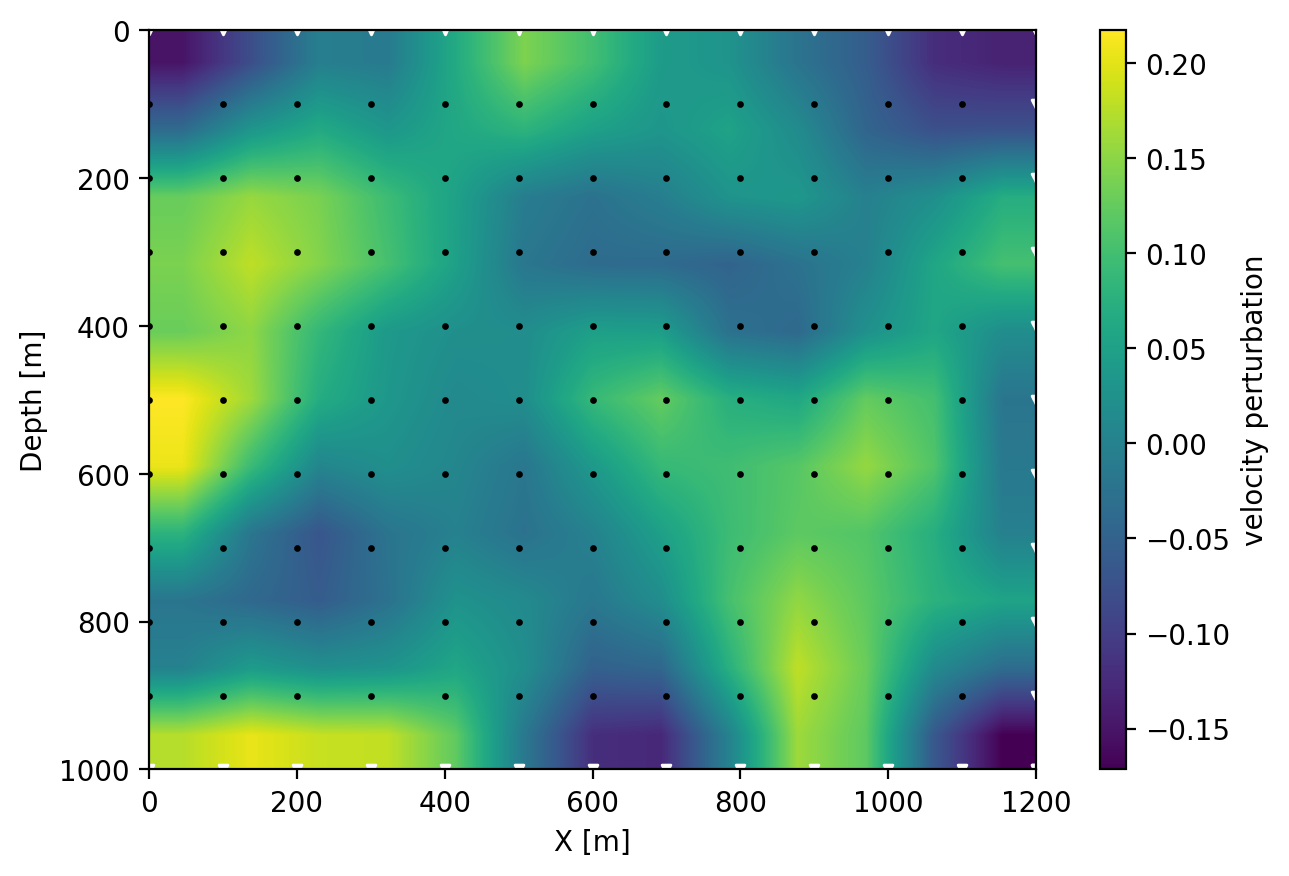

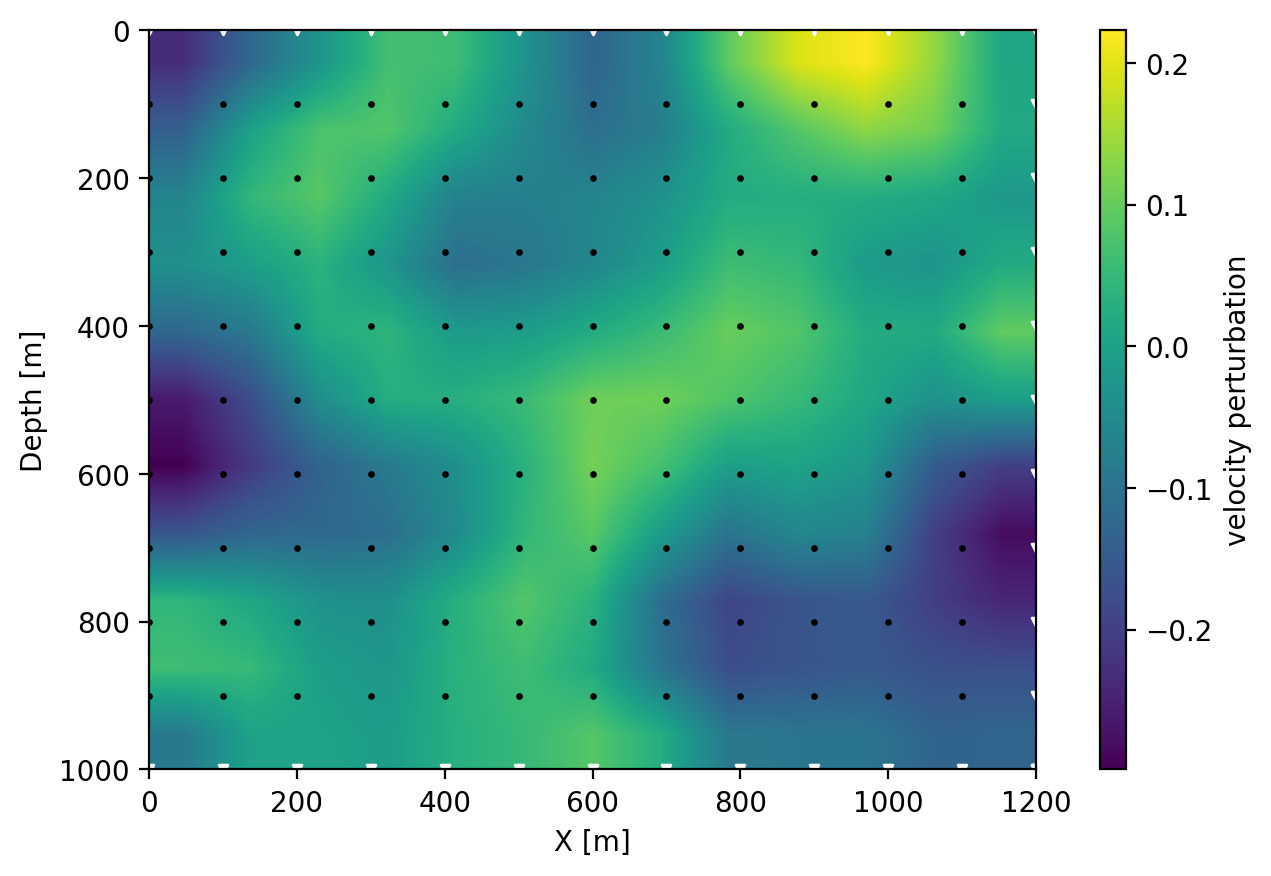

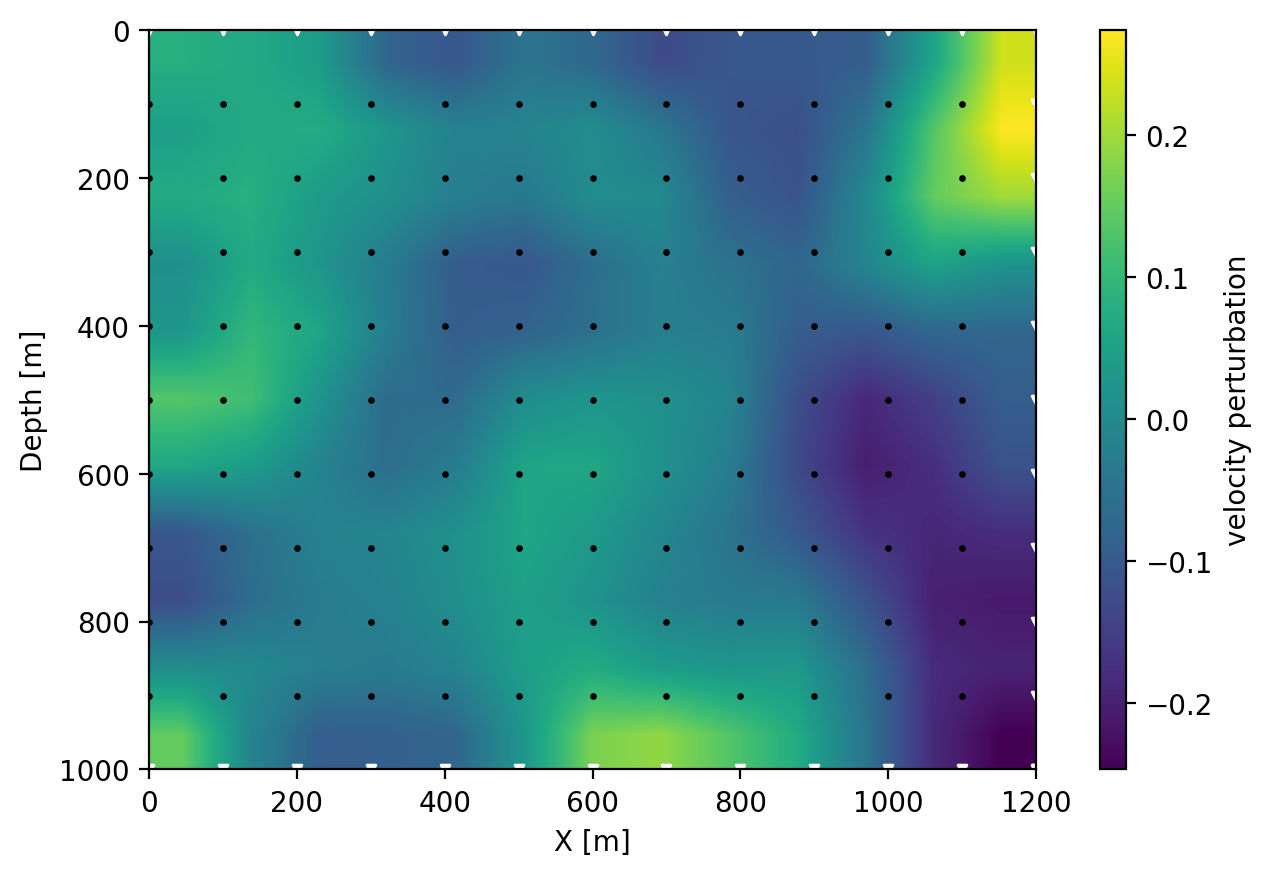

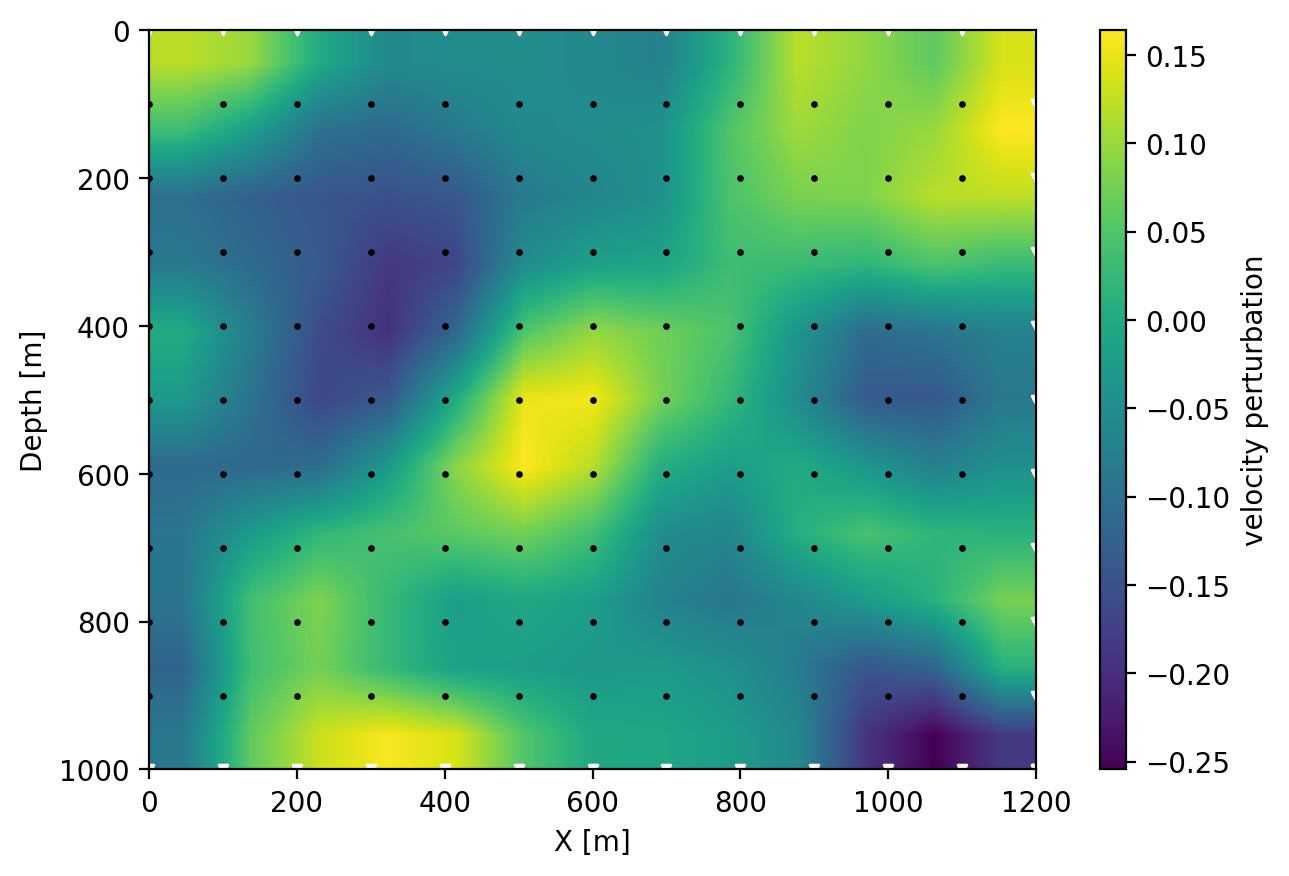

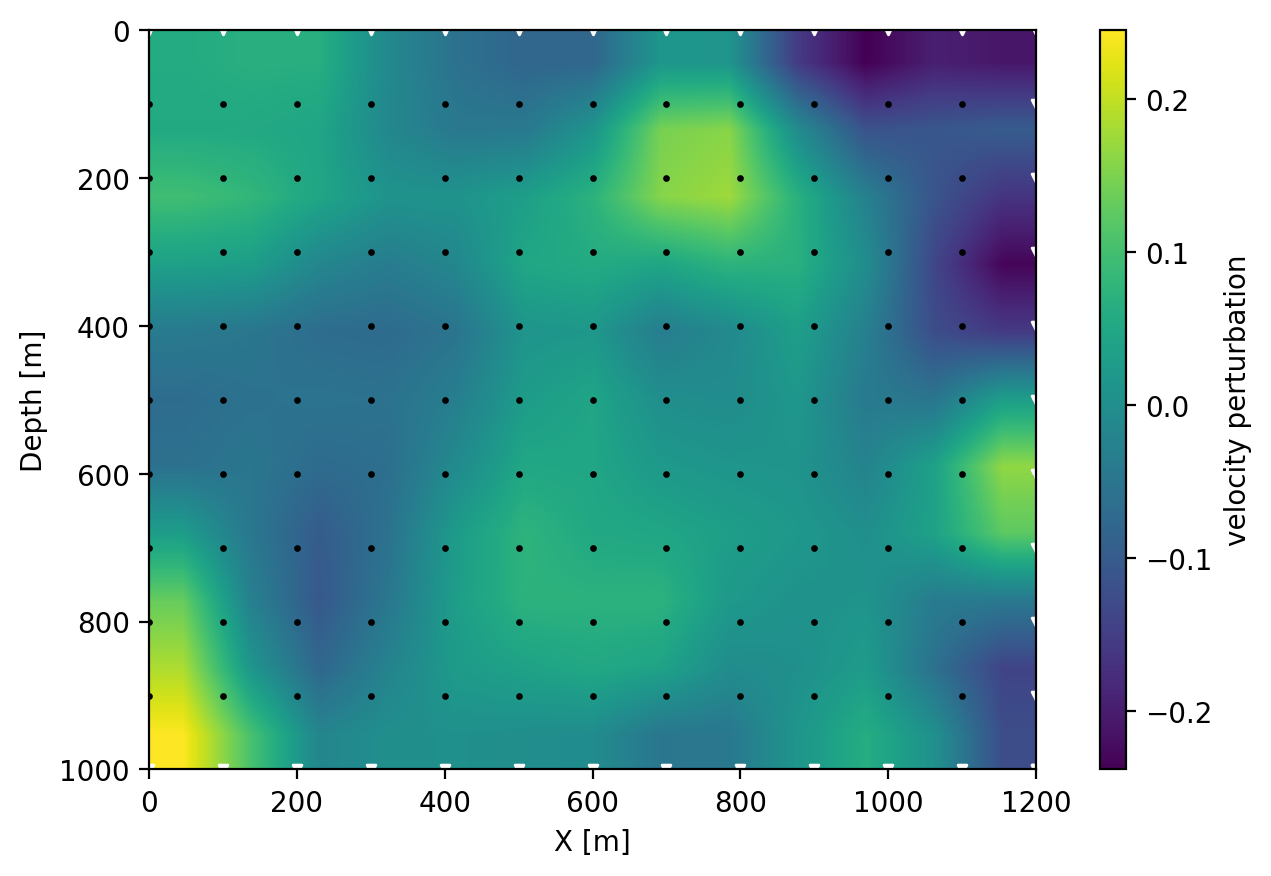

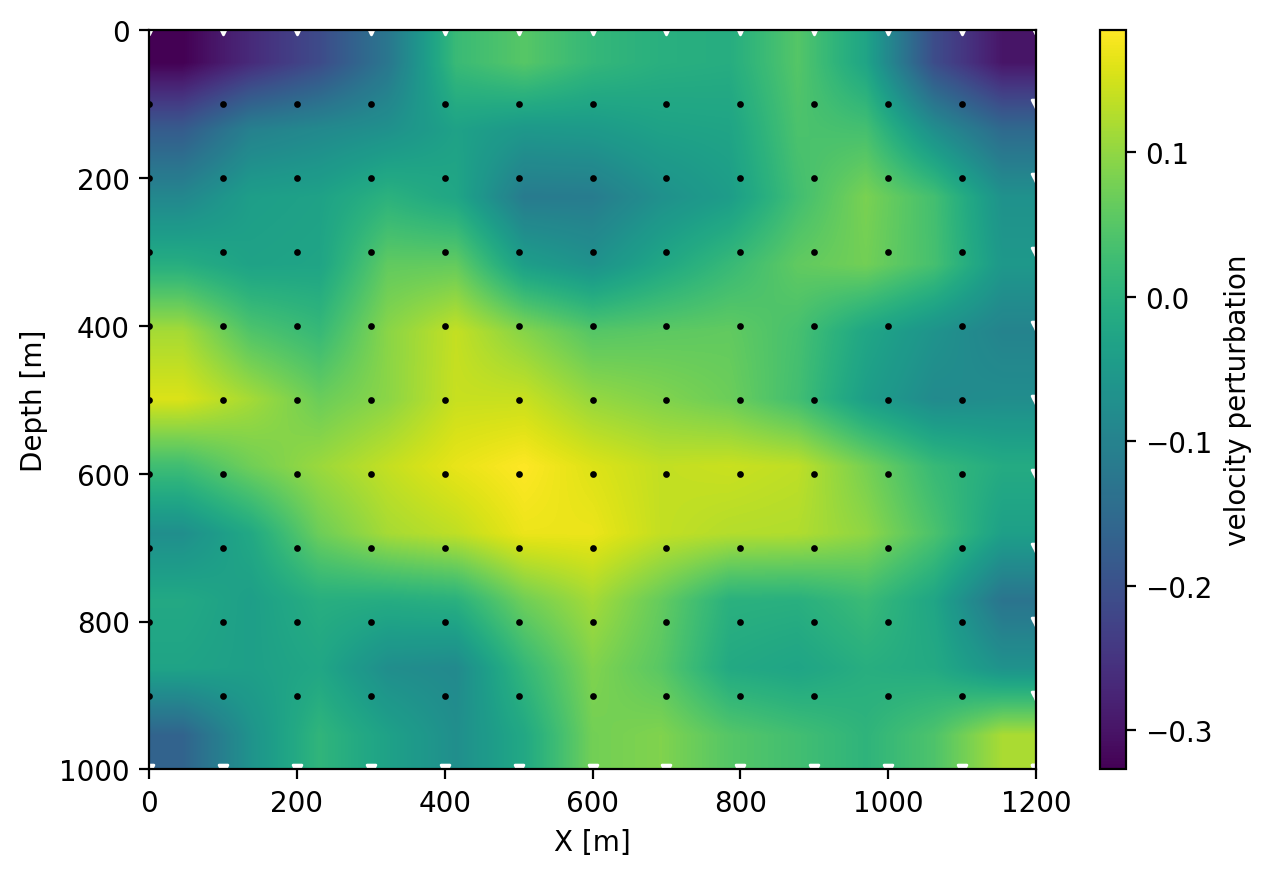

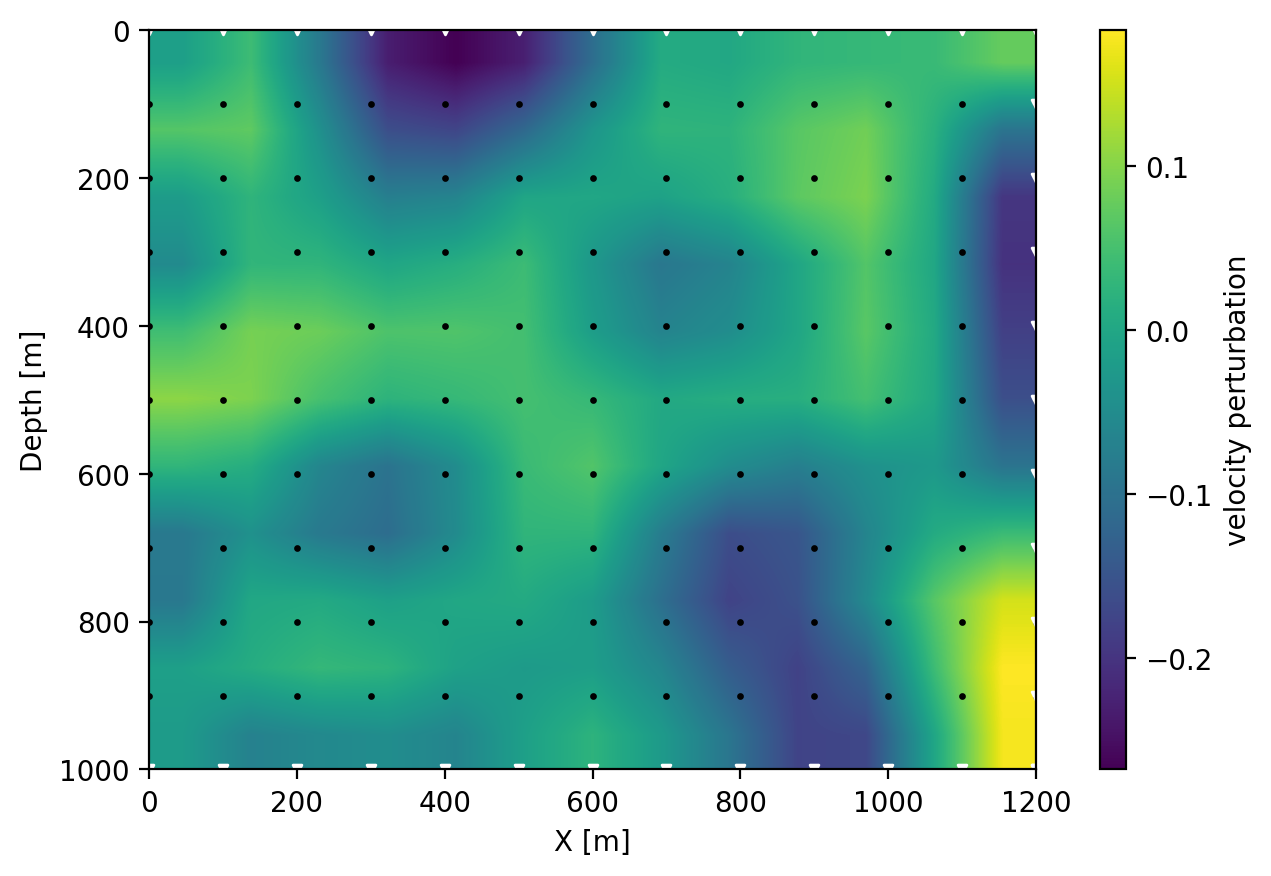

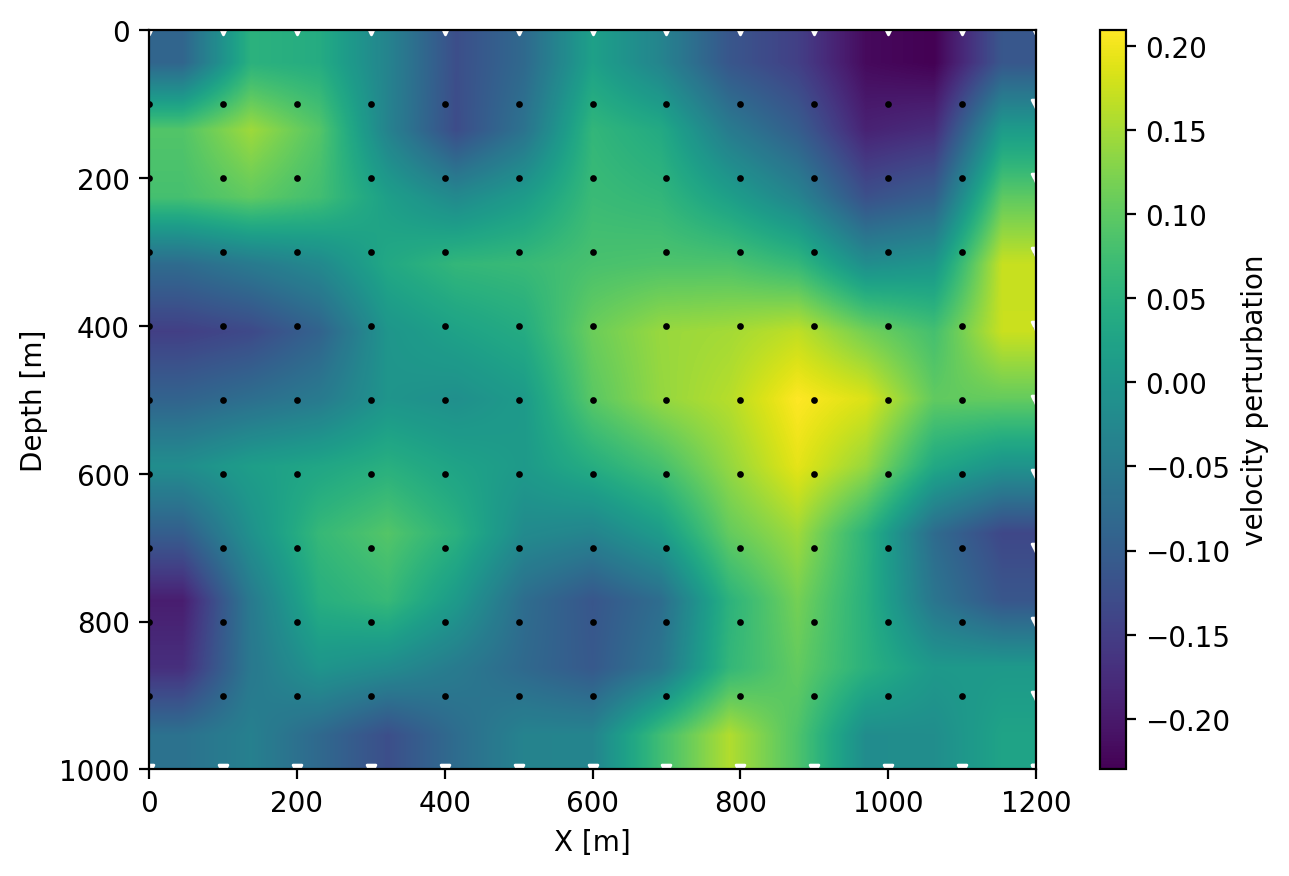

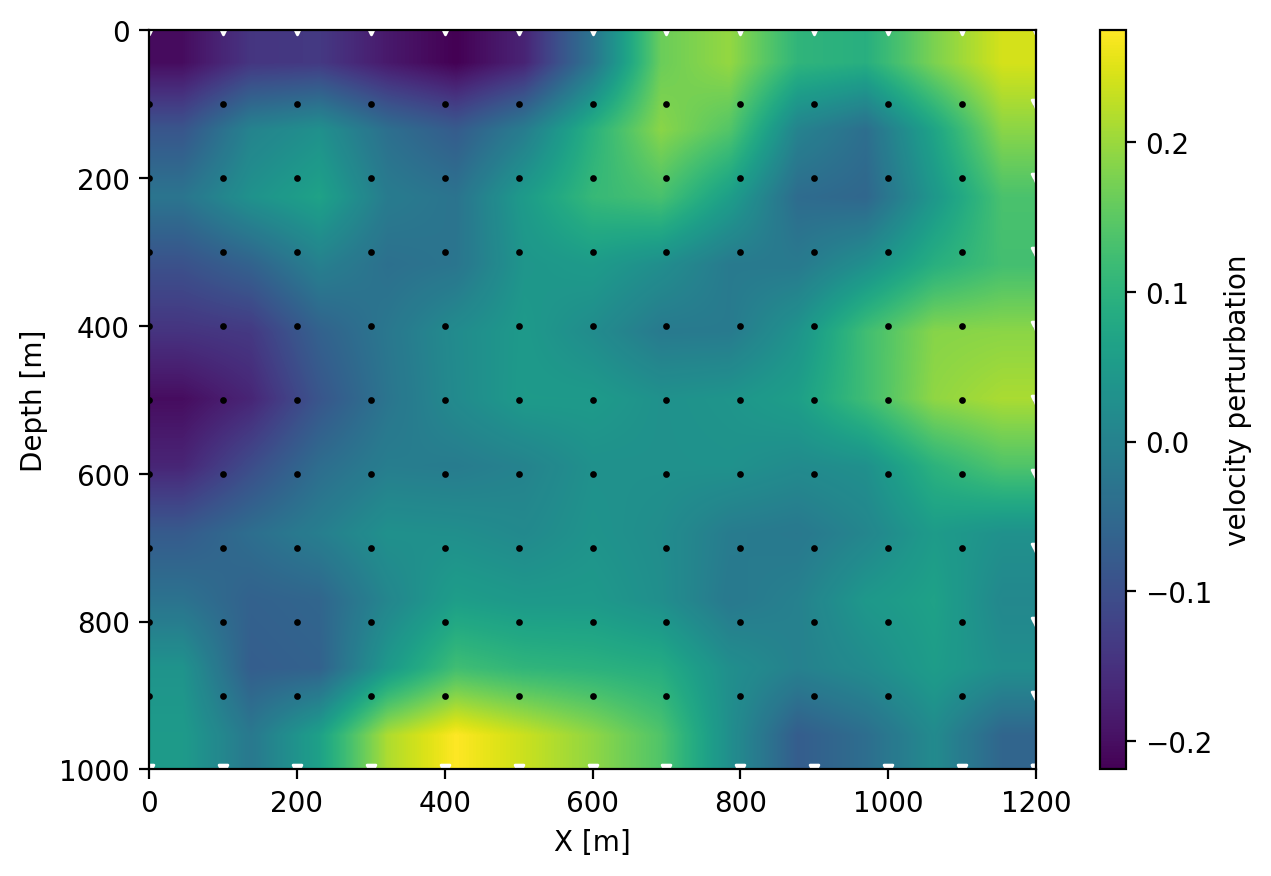

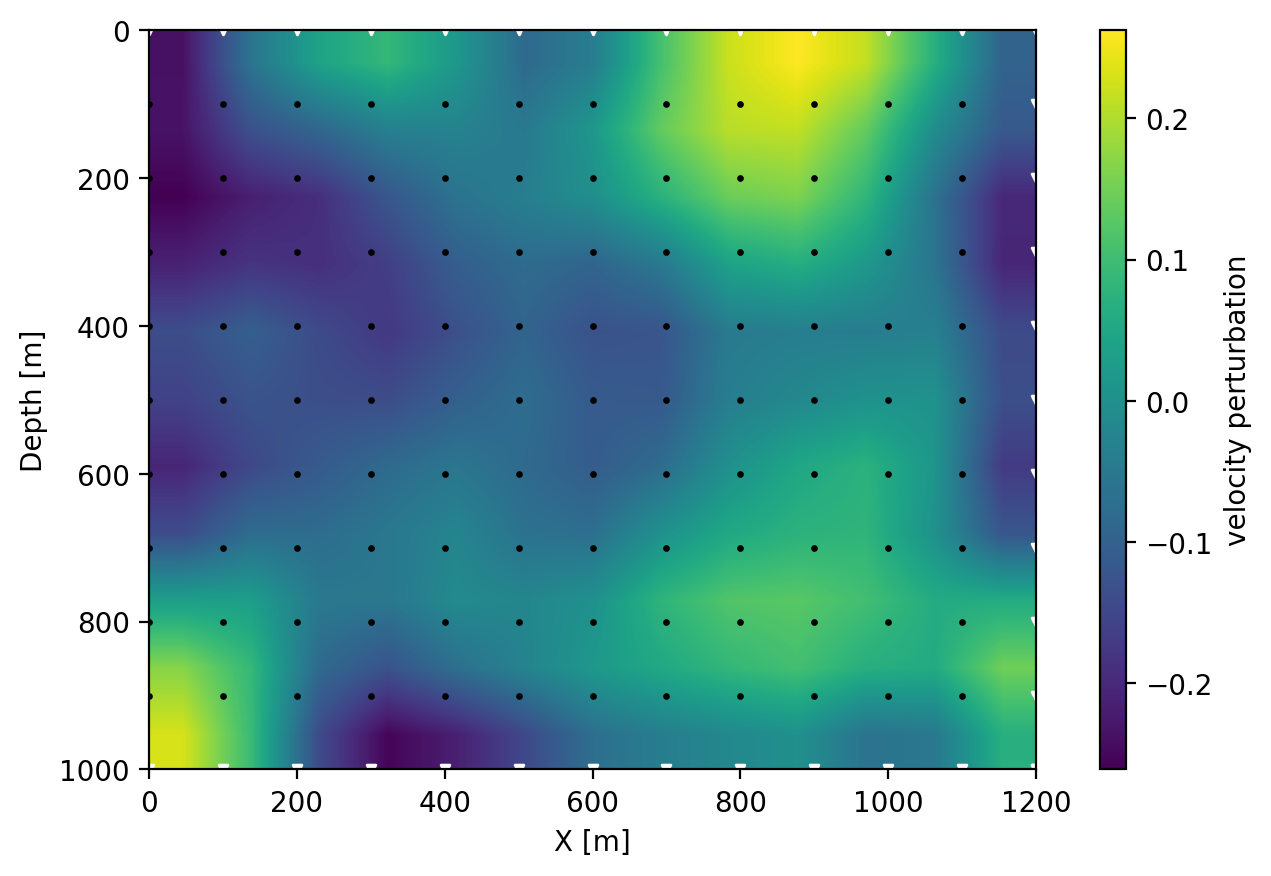

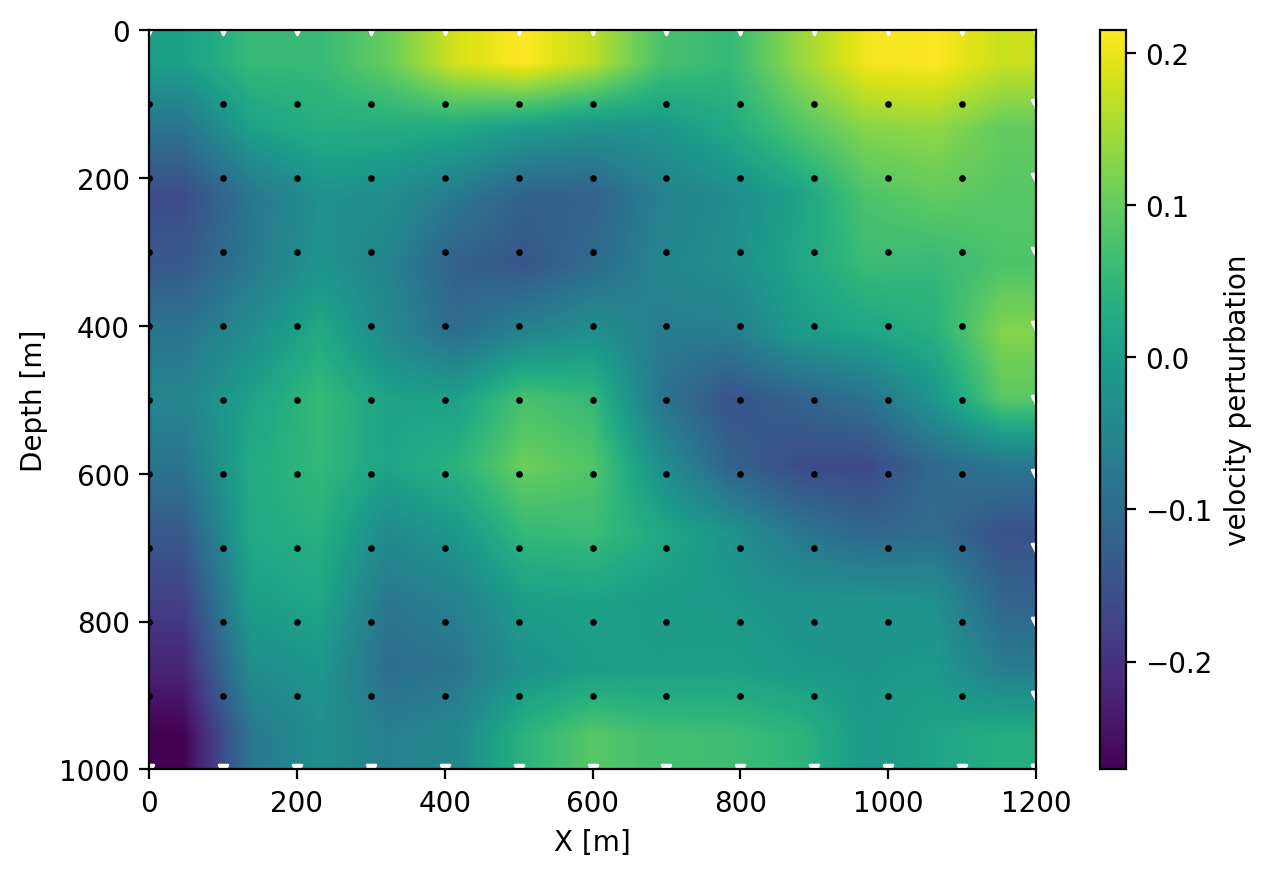

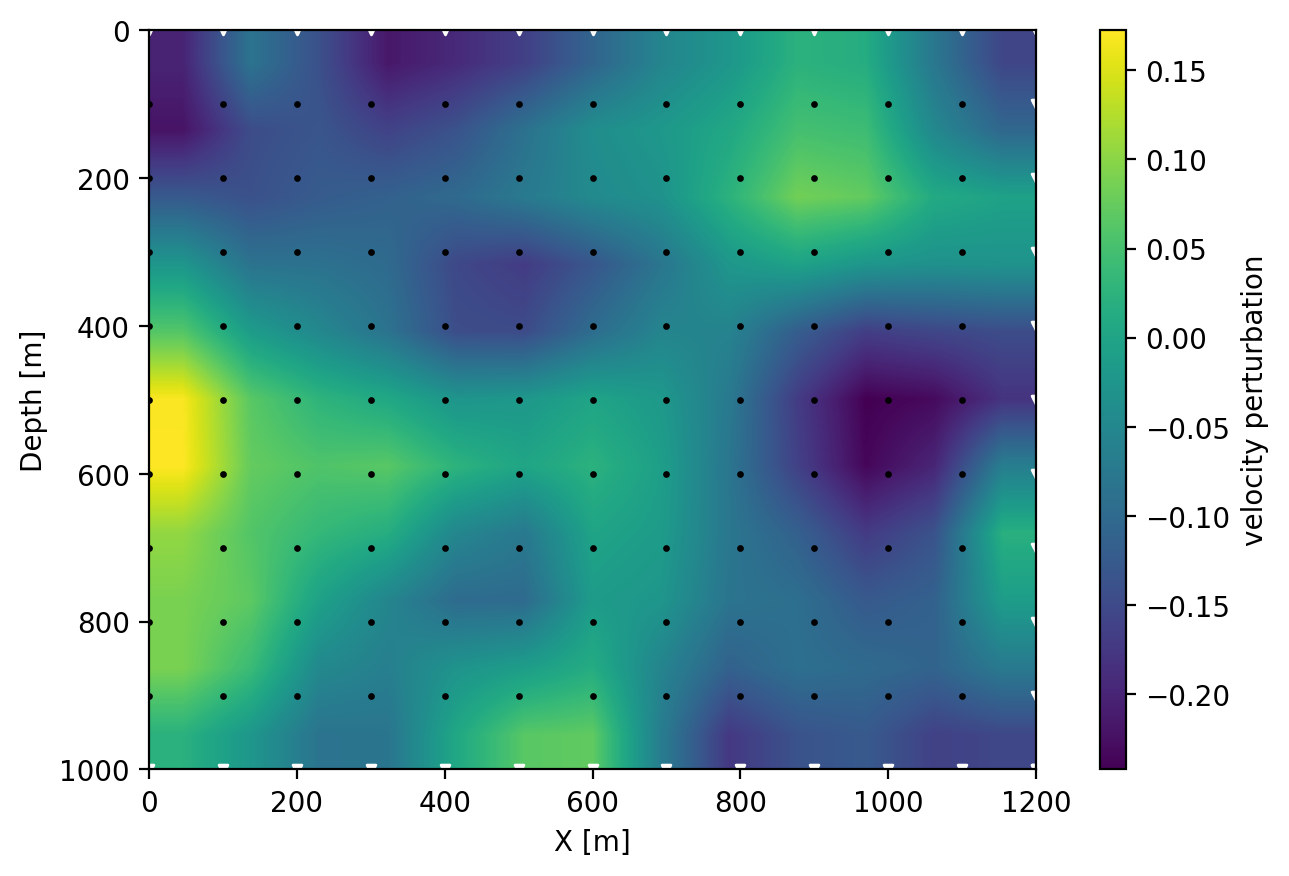

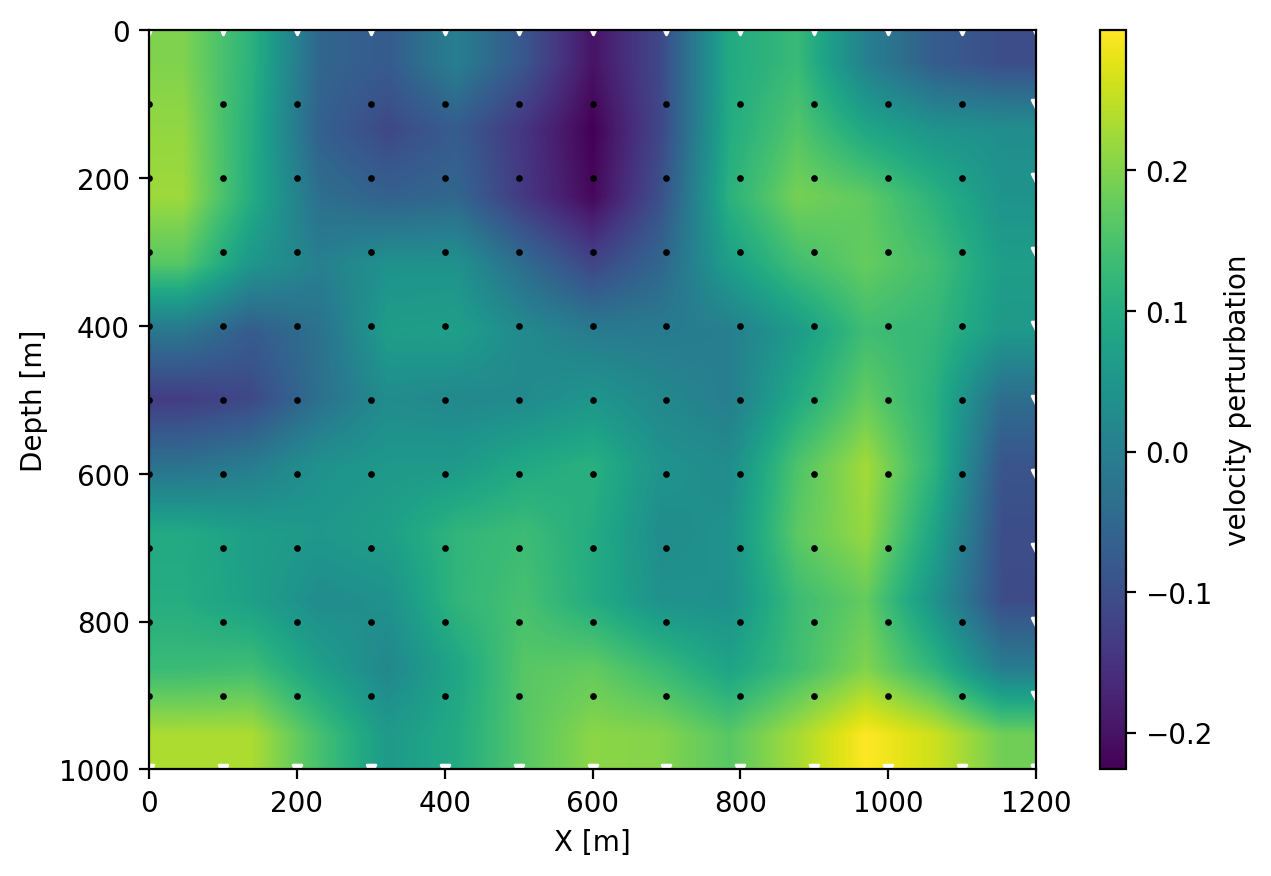

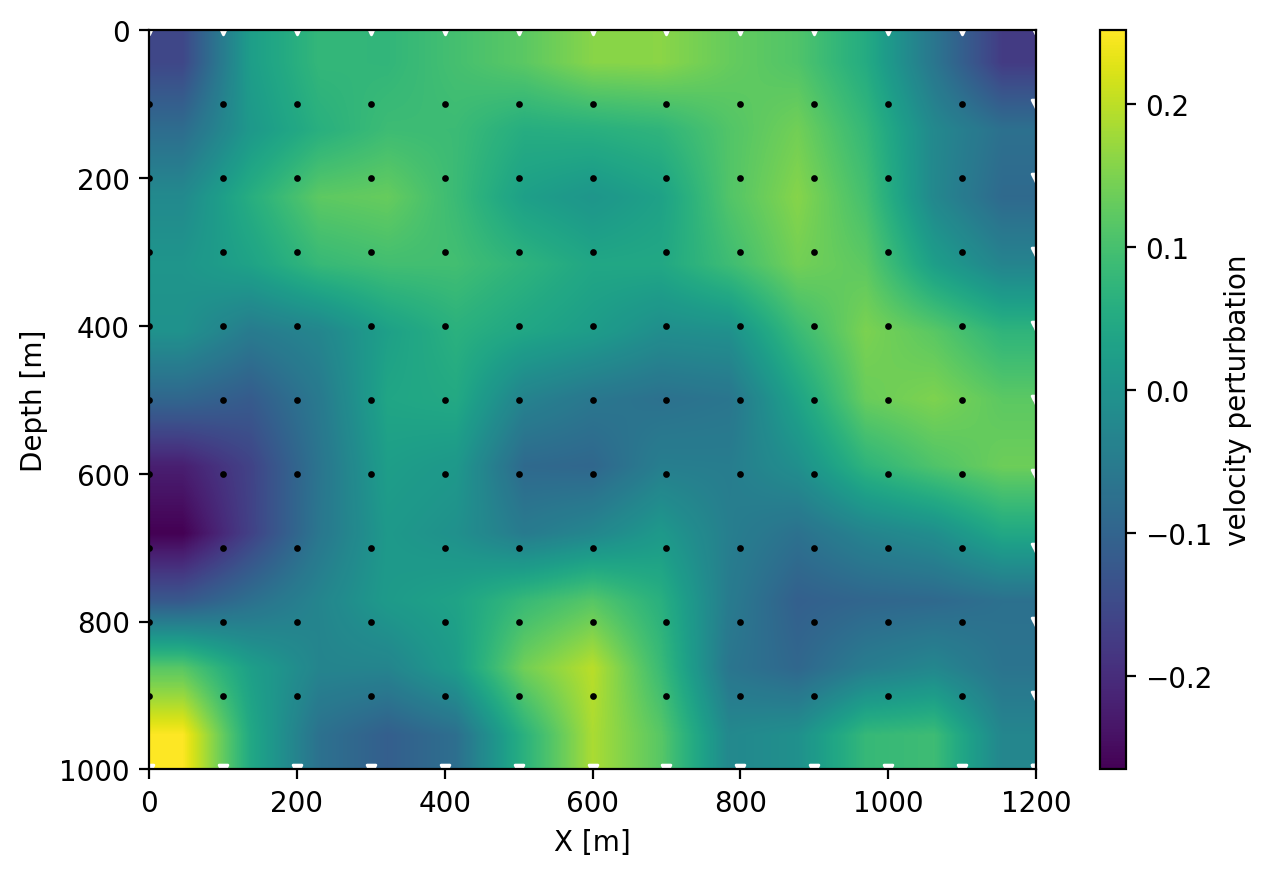

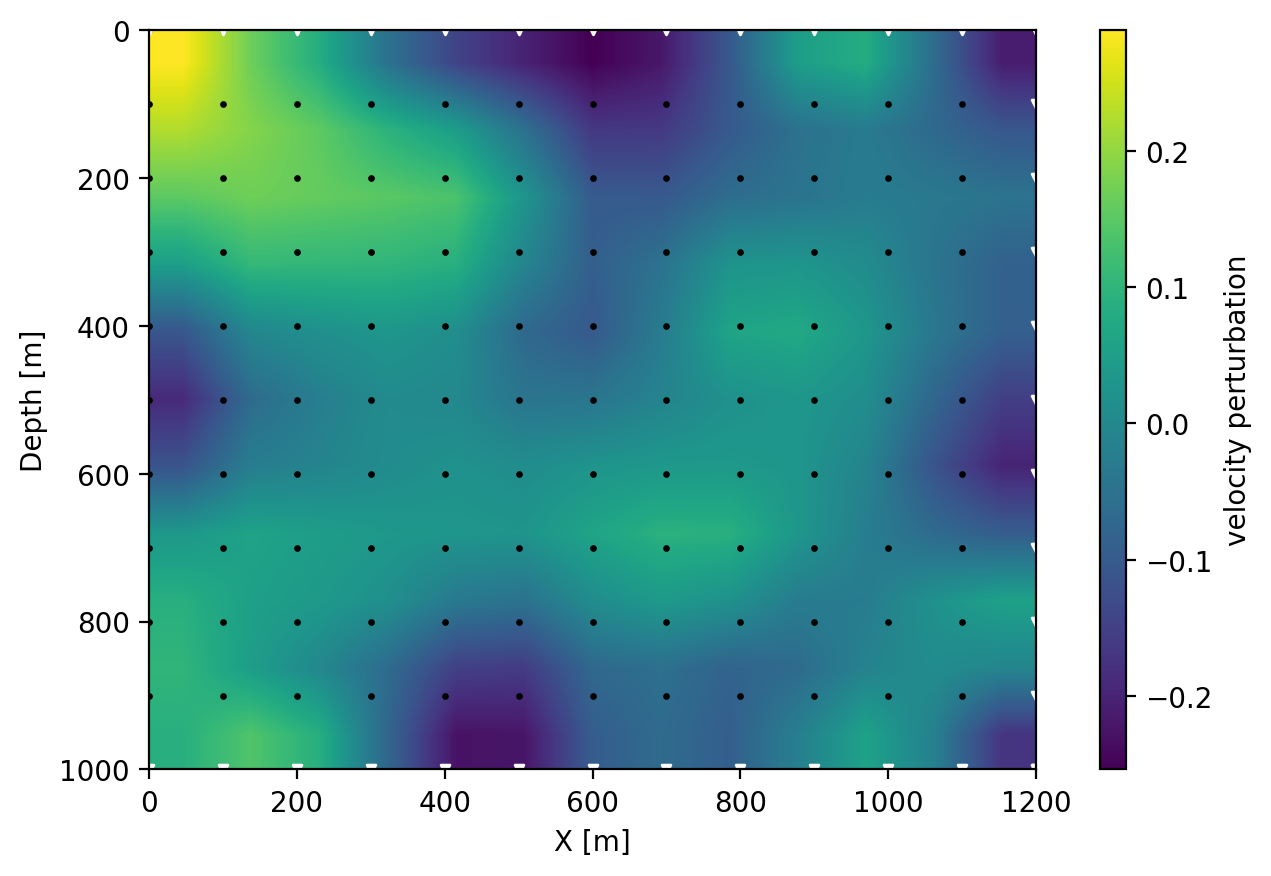

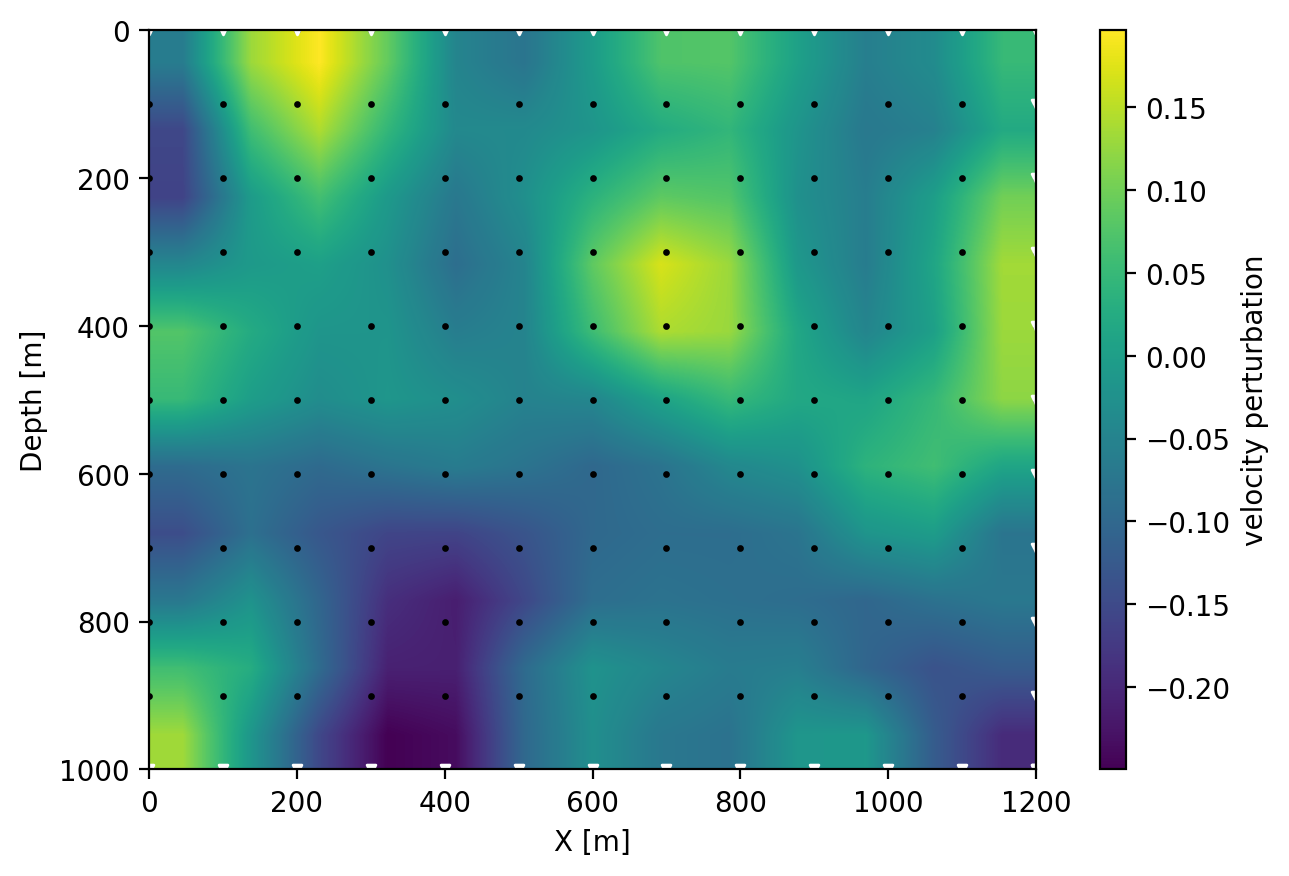

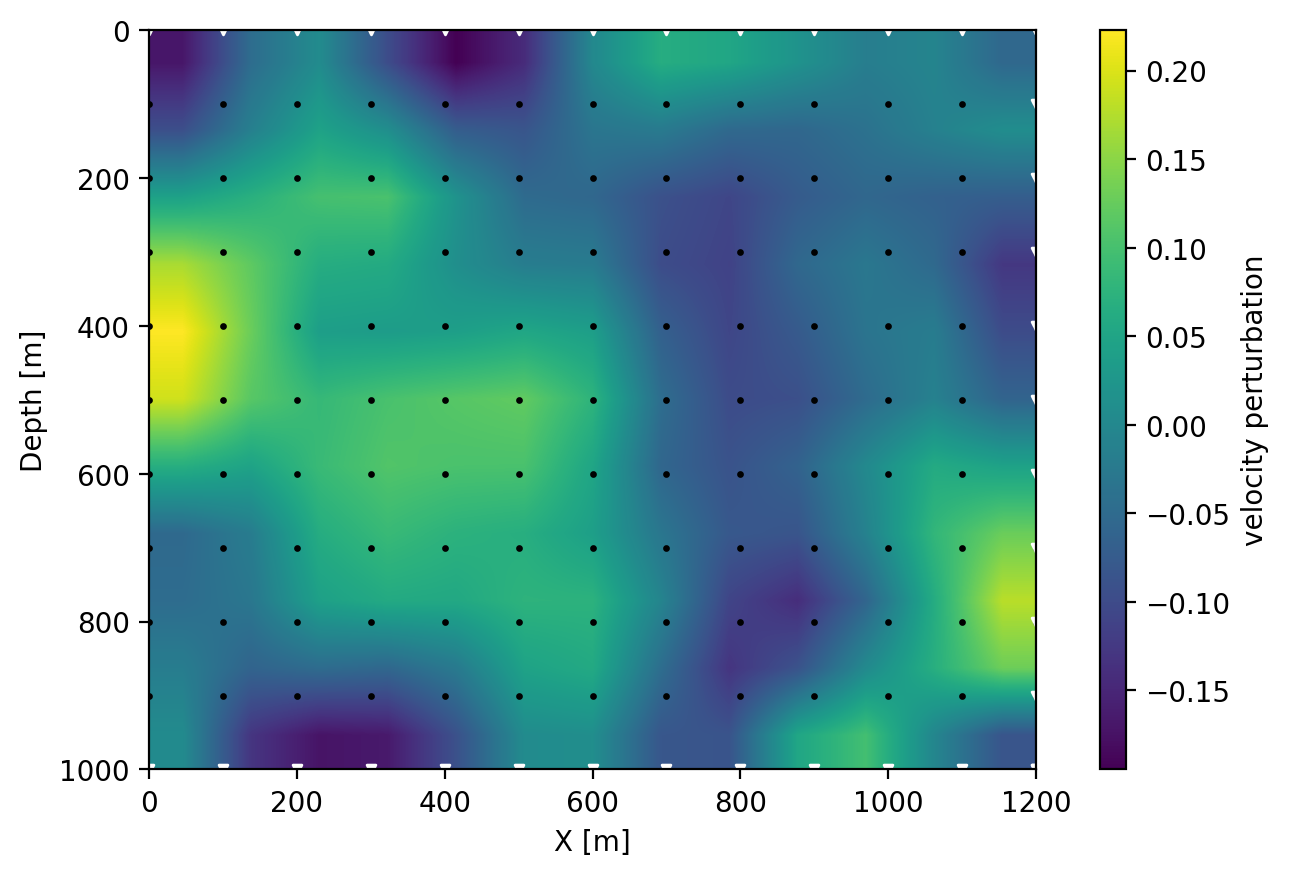

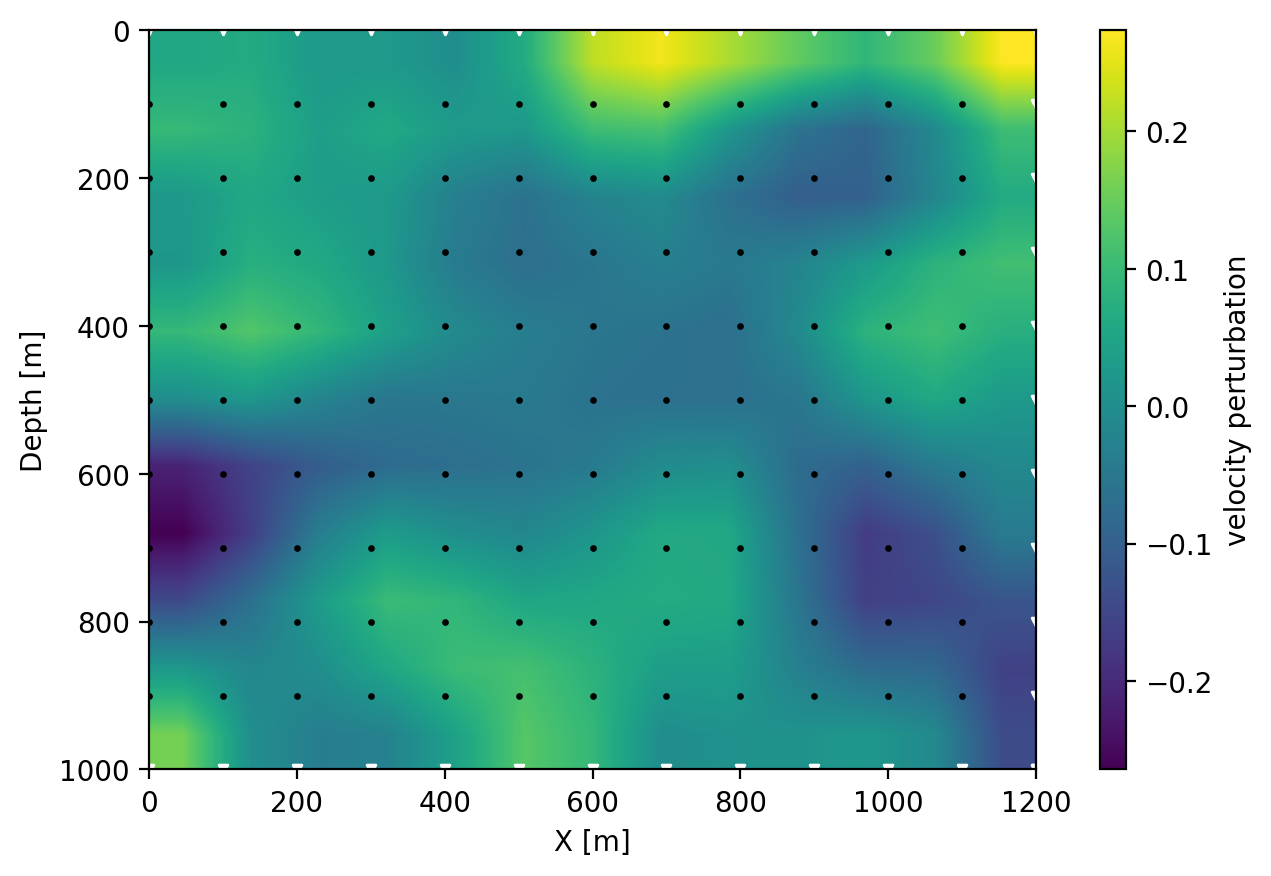

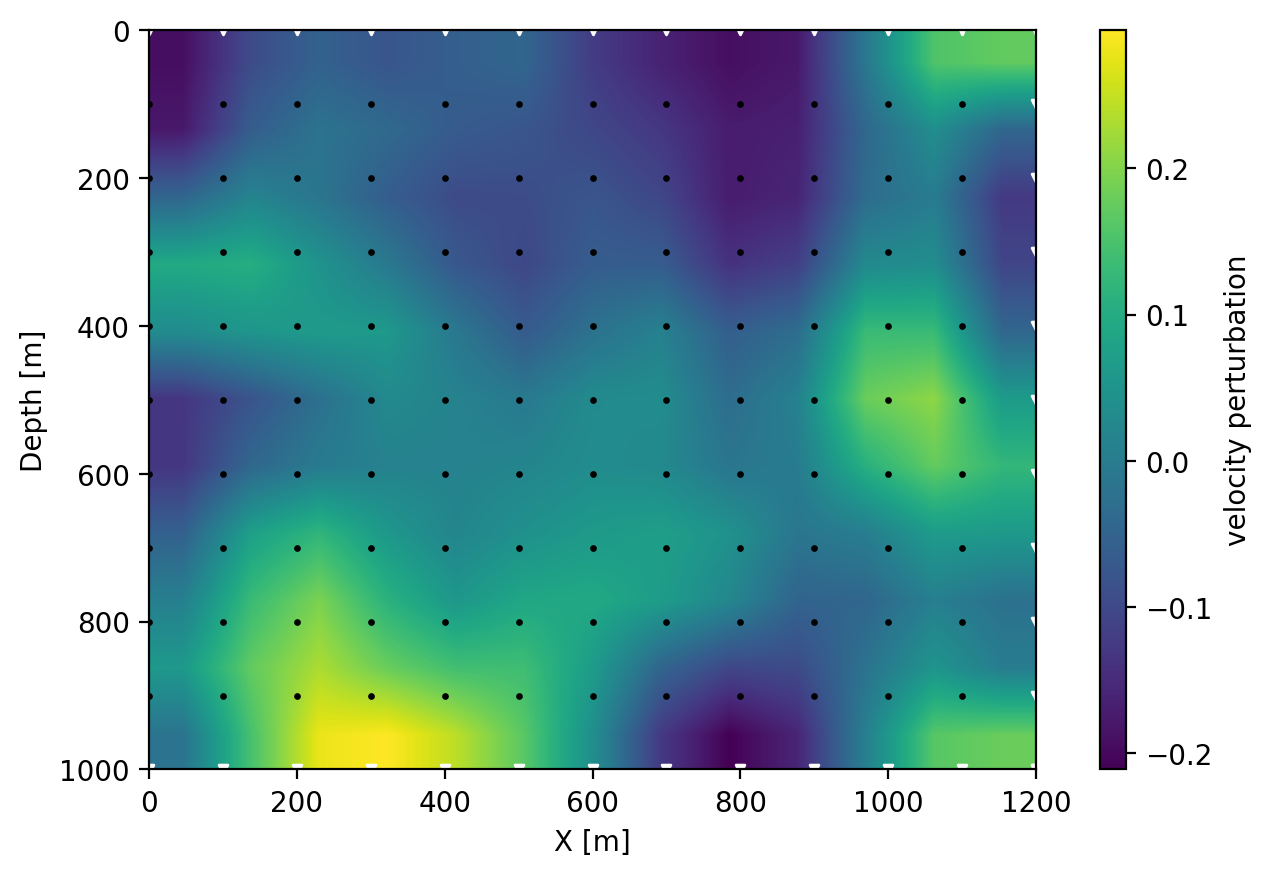

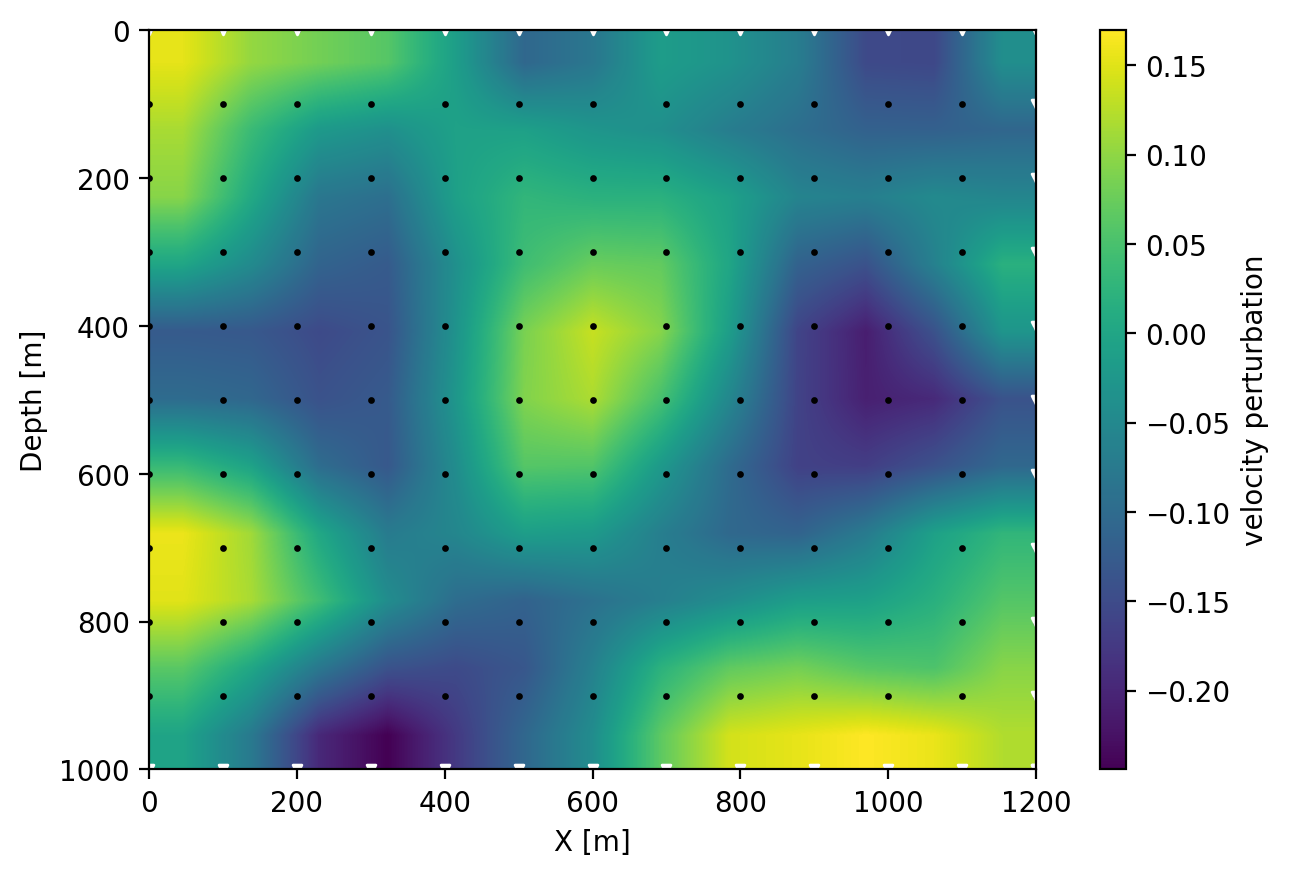

In [44]:
ExampleInputDir = '../Runs/CartesianRandomModelExample/input'

for imodel in np.arange(0,20):

    ModeName = 'CartesianStandardRandomModel%04d' %imodel
    EventParDir='../Runs/%s' %(ModeName)  
    if not os.path.exists(EventParDir):
        os.makedirs(EventParDir)
    print(EventParDir, " created")

    if not os.path.exists(EventParDir+'/input'):
        os.makedirs(EventParDir+'/input')

    shutil.copy(ExampleInputDir+'/inparam.model.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.nr.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.advanced.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.source.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.output.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/Synthetic_Stations_Cartesian.txt',EventParDir+'/input/')


    # # generate random model

    # # Our 2-dimensional distribution will be over variables grid_lat and grid_lon
    scale = 2
    sigma = 1

    grid_depth = np.linspace(0, 1000, 11)
    grid_x = np.linspace(0, 1200, 13)
    grid_y = np.linspace(-2000, 2000, 2)

    # Make sure RADISU and Coordinates are ascendingly sorted
    grid_depth.sort()
    grid_x.sort()
    grid_y.sort()

    GridX, GridY, GridDepth = np.meshgrid(grid_x, grid_y, grid_depth, indexing='ij')
    # MLtomo_ptb =np.random.normal(loc=0.0, scale=0.05, size=(len(grid_x), len(grid_y), len(depth)))

    # random uniform distribution between [0 - 1)
    tomorange = 0.5
    # MLtomo_ptb = (np.random.rand(len(grid_x), len(grid_y), len(grid_depth)) - 0.5)/0.5*tomorange
    MLtomo_ptb = (np.random.rand(len(grid_x), len(grid_depth)) - 0.5)/0.5*tomorange
    MLtomo_ptb_smooth = gaussian(MLtomo_ptb, sigma=sigma)
    # MLtomo_ptb_smooth = MLtomo_ptb_smooth/np.max(abs(MLtomo_ptb_smooth))*tomorange


    # Locate y=0 slice
    # y_index = np.where(grid_y==0)[0][0]
    # y_index = 0

    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure(dpi=200)
    ax = fig.gca()
    # ax = fig.gca(projection='3d')

    extent = np.min(grid_x), np.max(grid_x), np.min(grid_depth), np.max(grid_depth)
    PLOT = ax.imshow(MLtomo_ptb_smooth[:,:].T, cmap=cm.viridis, interpolation='bilinear', extent=extent, origin='lower')

    plotgrid_x, plotgrid_depth = np.meshgrid(grid_x, grid_depth)
    ax.scatter(plotgrid_x, plotgrid_depth, s=2, color='k')

    # Plot top surface stations
    for X in np.linspace(0,1200,13):
        ax.scatter(X,0,marker='v', s=10, color='w')
    # Plot Right boundary stations
    for Y in np.linspace(0,1000,11):
        ax.scatter(1200,Y,marker='v', s=10, color='w')
    # # Plot Bottom boundary stations
    for X in np.linspace(0,1200,13):
        ax.scatter(X,1000,marker='v', s=10, color='w')

    ax.set_aspect(1)
    ax.set_xlabel("X [m]")
    ax.set_ylabel("Depth [m]")
    ax.set_xlim(0,1200)
    ax.set_ylim(0,1000)
    ax.invert_yaxis()
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().y1-ax.get_position().y0])
    cbar = plt.colorbar(PLOT, cax=cax)
    cbar.set_label('velocity perturbation')




    MLtomo_ptb_nc = np.stack((MLtomo_ptb_smooth, MLtomo_ptb_smooth),axis=1)
    ## smooth the random model 
    # MLtomo_ptb_smooth = gaussian(MLtomo_ptb, sigma=sigma)
    # MLtomo_ptb[:,:,0] = np.zeros(np.shape(MLtomo_ptb[:,:,0]))
    print(MLtomo_ptb_nc.min(), MLtomo_ptb_nc.max())








    # write to file
    if os.path.exists(EventParDir+'/input/'+'cartesian_random_tomo.nc'):
        os.remove(EventParDir+'/input/'+'cartesian_random_tomo.nc')

    nc = Dataset(EventParDir+'/input/'+'cartesian_random_tomo.nc', 'w')
    nc.createDimension('nx', size=len(grid_x))
    nc.createDimension('ny', size=len(grid_y))
    nc.createDimension('ndepth', size=len(grid_depth))
    nc.createVariable('x', float, dimensions=('nx'))
    nc['x'][:] = grid_x
    nc.createVariable('y', float, dimensions=('ny'))
    nc['y'][:] = grid_y
    nc.createVariable('depth', float, dimensions=('ndepth'))
    nc['depth'][:] = grid_depth
    nc.createVariable('dvp', float, dimensions=('nx', 'ny','ndepth'))
    nc['dvp'][:,:,:] = MLtomo_ptb_nc[:,:,:]

    if imodel == 0:
        nc['dvp'][:,:,:] = np.zeros(np.shape(MLtomo_ptb_nc[:,:,:]))
        nc.close()
        continue


    nc.close()

    # shutil.copy(ExampleInputDir+'/TomoNet_LowerMantle__10s.e',EventParDir+'/input/')




In [12]:
np.linspace(100, 2000.001, 20)

array([ 100.        ,  200.00005263,  300.00010526,  400.00015789,
        500.00021053,  600.00026316,  700.00031579,  800.00036842,
        900.00042105, 1000.00047368, 1100.00052632, 1200.00057895,
       1300.00063158, 1400.00068421, 1500.00073684, 1600.00078947,
       1700.00084211, 1800.00089474, 1900.00094737, 2000.001     ])